In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

      phase speed     phase
Mean    -0.000002 -6.359112
Std      0.008713  2.486367
Var      0.000076  6.182020


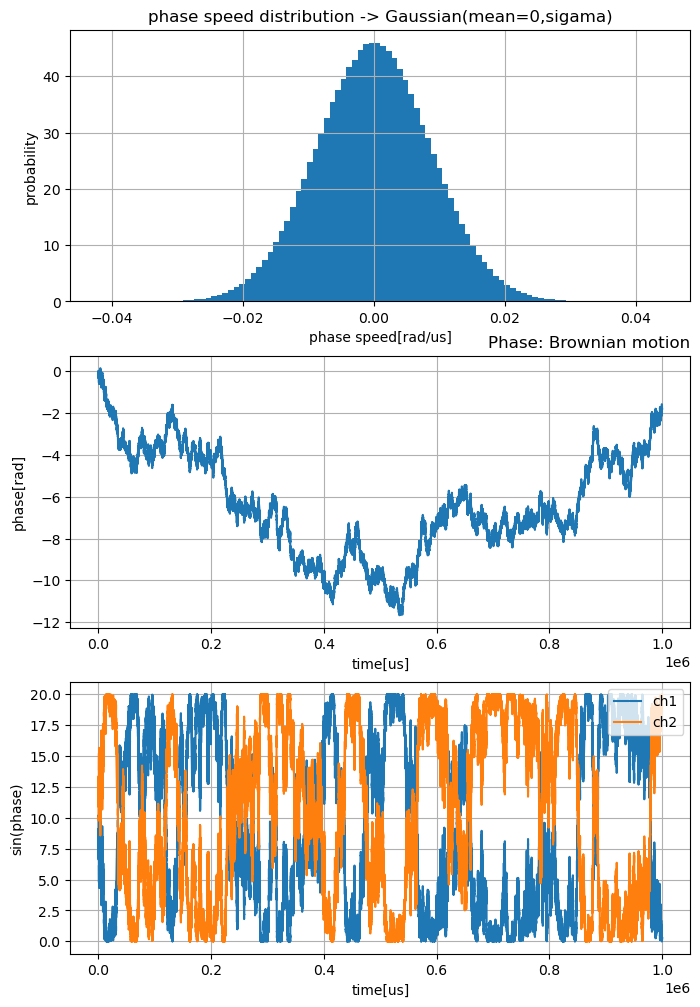

In [2]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.5/180*np.pi #rad/us
SIG_AMP=10 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

In [4]:
def get_phase_from_count(ch1,ch2):
    if ch1+ch2==0:
        return 0
    else:
        return np.arcsin((ch1-ch2)/(ch1+ch2))

def measure_count(sig,method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    if method==0:
        return sig[-1]
    elif method==1:
        return sig.sum()
    elif method==2:
        return rng.poisson(sig.sum())
    
def phase_to_dict(phase_measure_M4,phase_fb_M4,phase_measure_inter_M4,phase_fb_inter_M4,phase_M4):
    return dict(measure_quick=phase_measure_M4.tolist(),
                fb_quick=phase_fb_M4.tolist(),
                measure_inter=phase_measure_inter_M4.tolist(),
                fb_inter=phase_fb_inter_M4.tolist(),
                phase=phase_M4[:,-1].reshape(-1).tolist())

ki=0

time_exposure=100 #us
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
sig_ch1_measure=np.zeros(sig_ch1_exposure.shape[0])#测量值
sig_ch2_measure=np.zeros(sig_ch2_exposure.shape[0])#测量值
phase_speed_M1=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M1=np.zeros_like(phase_speed_M1)
phase_measure_M1=np.zeros(phase_speed_M1.shape[0]) # 测量出的反馈量
phase_measure_inter_M1=np.zeros(phase_speed_M1.shape[0]) # 测量出的反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M1[i]=np.cumsum(phase_speed_M1[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M1[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M1[i],2)
    ###引入shot noise
    ch1_measure=measure_count(sig_ch1_exposure[i],2)#rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
    ch2_measure=measure_count(sig_ch2_exposure[i],2)#rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
    sig_ch1_measure[i]=ch1_measure
    sig_ch2_measure[i]=ch2_measure
    phase_measure_M1[i]=get_phase_from_count(ch1_measure,ch2_measure)
    phase_measure_inter_M1[i]=get_phase_from_count(sig_ch1_exposure[:i+1].sum(),sig_ch2_exposure[:i+1].sum())
    #phase_measure_M1[i]=phase_M1[i,-1]
    
    ##---反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M1[i+1,0]-=phase_measure_M1[i]#fb_weight(phase_measure_M1[i],time_exposure) # 反馈到下一个exposure
        #phase_speed_M1[i+1,0]-=ki*phase_measure_inter_M1[i] # 反馈到下一个exposure

    phase_offest=phase_M1[i,-1]
phase_out_M1=np.cumsum(phase_speed_M1.reshape(-1))
push_data(phase_out_M1,'phase M1')

100%|██████████| 10000/10000 [00:11<00:00, 837.80it/s] 

      phase speed     phase  phase M1
Mean    -0.000002 -6.359112 -0.000198
Std      0.008713  2.486367  0.083214
Var      0.000076  6.182020  0.006925


In [140]:
time_exposure=100 #us
def general_pi(phase_speed,time_exposure=2,kp=1,ki=1):
    
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M4=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M4=np.zeros_like(phase_speed_M4)
    sig_ch1_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量ch1
    sig_ch2_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量ch2
    phase_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量
    phase_measure_inter_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 积分测量量
    phase_fb_inter_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 积分反馈量
    phase_fb_M4=np.zeros(phase_speed_M4.shape[0]) # 反馈量
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M4[i]=np.cumsum(phase_speed_M4[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M4[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M4[i],2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
        sig_ch1_measure_M4[i]=ch1_measure
        sig_ch2_measure_M4[i]=ch2_measure
        phase_measure_M4[i]=get_phase_from_count(ch1_measure,ch2_measure)        
        phase_fb_M4[i]=kp*phase_measure_M4[i]
        
        ##-- 反馈 
        if i<(sig_ch1_exposure.shape[0]-1):
            phase_speed_M4[i+1,0]-=phase_fb_M4[i]#/time_exposure # 反馈到下一个exposure
            ### 根据前time_inter*time_exposure项的积分去修正相位
            if i>=20:
                phase_measure_inter_M4[i]=get_phase_from_count(sig_ch1_measure_M4[i-10:i+1].sum(),sig_ch2_measure_M4[i-10:i+1].sum())
                #phase_measure_inter_M4[i]=sig_ch1_measure_M4[:i+1].sum()-sig_ch2_measure_M4[:i+1].sum()
                phase_fb_inter_M4[i]=ki*phase_measure_inter_M4[i]
                phase_speed_M4[i+1,0]-=phase_fb_inter_M4[i]
                
                

        phase_offest=phase_M4[i,-1]
    phase_out_M4=np.cumsum(phase_speed_M4.reshape(-1))
    #push_data(phase_out_M4,'phase M4 intergration')
    data_dict=phase_to_dict(phase_measure_M4,phase_fb_M4,
                        phase_measure_inter_M4,phase_fb_inter_M4,
                        phase_M4)
    return phase_out_M4,data_dict

phase_out,m1_pi=general_pi(phase_speed=phase_speed,time_exposure=100,kp=1,ki=0)
push_data(phase_out,'phase M1 pi')

100%|██████████| 10000/10000 [00:00<00:00, 36630.26it/s]

      phase speed     phase  phase M1  phase M1 pi  phase M1 i
Mean    -0.000002 -6.359112 -0.000198    -0.000198    0.000119
Std      0.008713  2.486367  0.083214     0.083214    0.082157
Var      0.000076  6.182020  0.006925     0.006925    0.006750


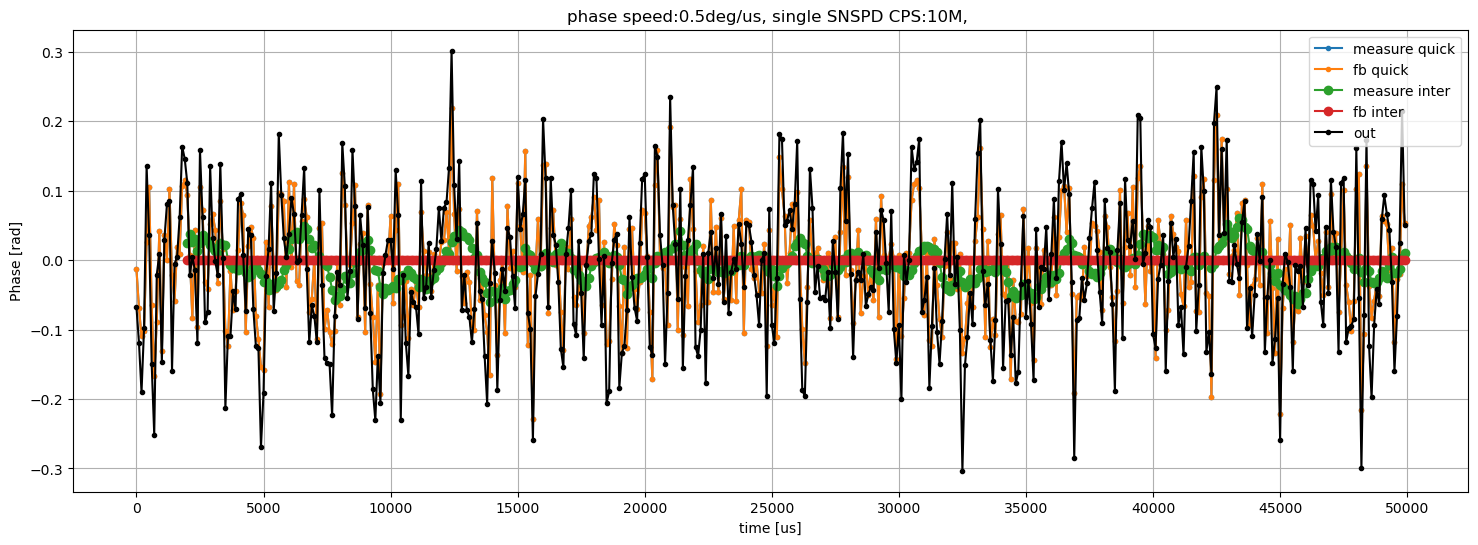

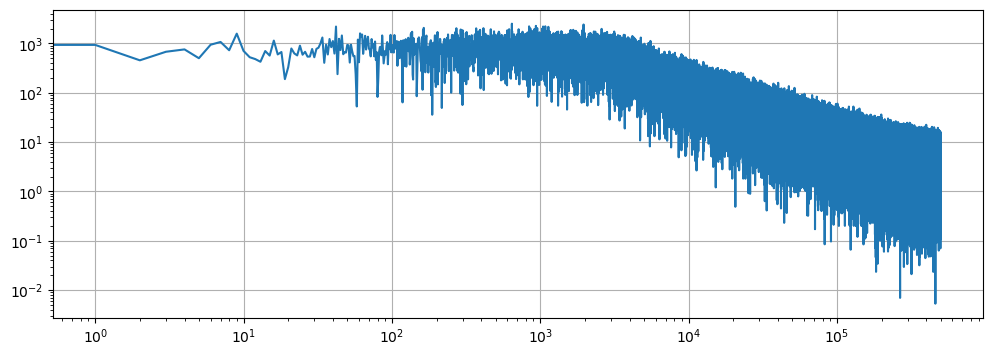

In [141]:
x0=0
x1=600
def plot_fb(graph_dict,x0=0,x1=300):
    plt.figure(figsize=(18,6))
    plt.plot(graph_dict['measure_quick'][x0:x1],'.-',label='measure quick')
    plt.plot(graph_dict['fb_quick'][x0:x1],'.-',label='fb quick')
    plt.plot(graph_dict['measure_inter'][x0:x1],'o-',label='measure inter')
    plt.plot(graph_dict['fb_inter'][x0:x1],'o-',label='fb inter')
    plt.plot(graph_dict['phase'][x0:x1],'.-k',label='out')
    plt.xticks(np.arange(0,x1-x0+1,(x1-x0)//10),labels=np.arange(x0,x1+1,(x1-x0)//10)*time_exposure)
    plt.legend(loc=1)
    plt.grid()
    plt.title('phase speed:{}deg/us, single SNSPD CPS:{}M, '.format(PHASE_SEEPD/np.pi*180,SIG_AMP))
    plt.xlabel('time [us]')
    plt.ylabel('Phase [rad]')
    plt.show()
plot_fb(m1_pi,x0=0,x1=500)

freq=np.fft.rfftfreq(phase_out.size,d=1e-6)
phase_fft=np.fft.rfft(phase_out)
plt.figure(figsize=(12,4))
plt.loglog(freq,np.abs(phase_fft))
plt.grid()

100%|██████████| 10000/10000 [00:00<00:00, 34722.55it/s]


      phase speed     phase  phase M1  phase M1 pi  phase M1 i
Mean    -0.000002 -6.359112 -0.000198    -0.000198   -0.000205
Std      0.008713  2.486367  0.083214     0.083214    0.088055
Var      0.000076  6.182020  0.006925     0.006925    0.007754


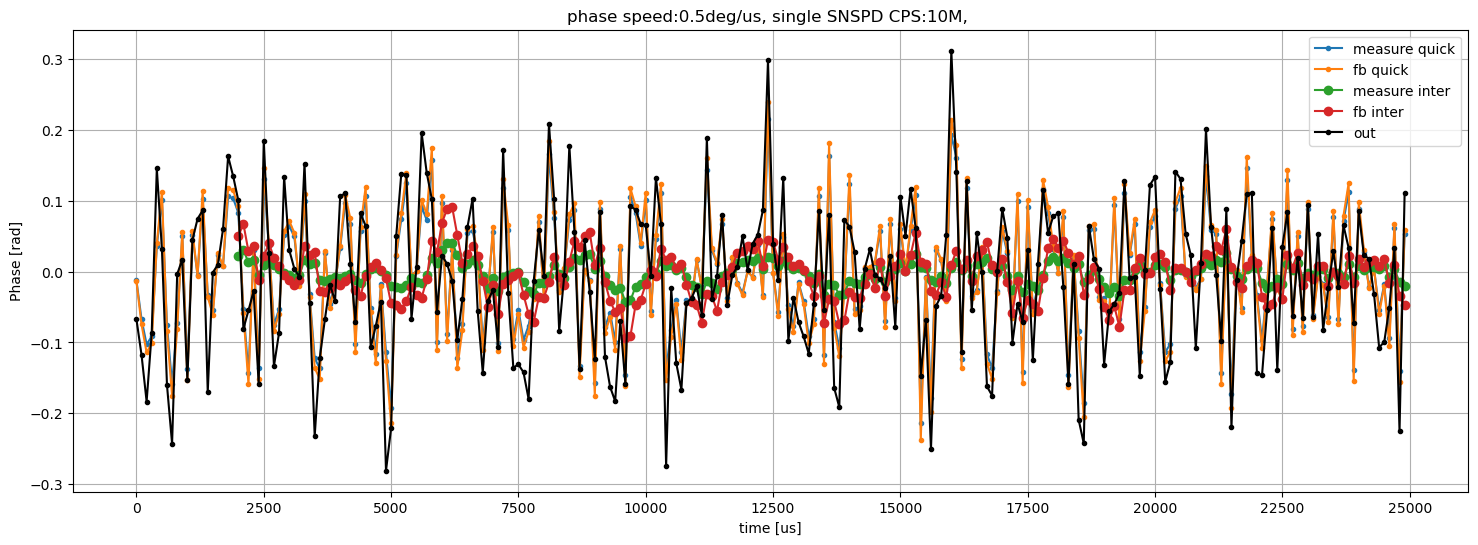

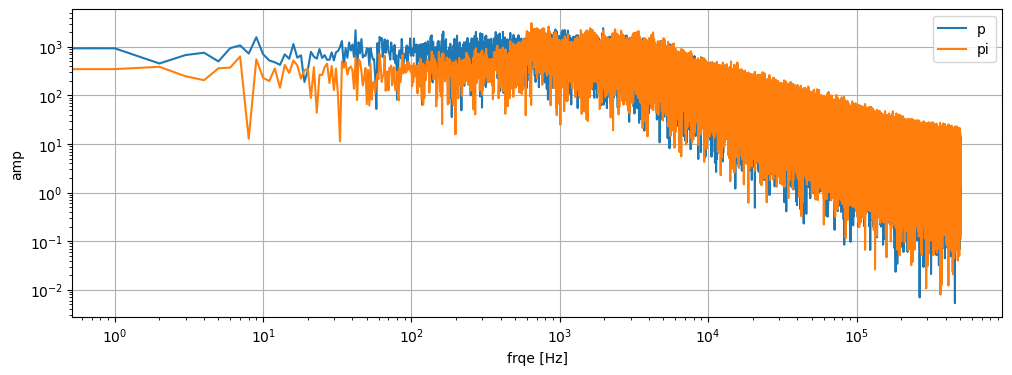

In [149]:
phase_out_b,m1_pi_b=general_pi(phase_speed=phase_speed,time_exposure=100,kp=1.11,ki=2.22)
push_data(phase_out_b,'phase M1 i')

plot_fb(m1_pi_b,x0=0,x1=250)

freq=np.fft.rfftfreq(phase_out_b.size,d=1e-6)
phase_fft=np.fft.rfft(phase_out_b)
plt.figure(figsize=(12,4))
plt.loglog(freq,np.abs(np.fft.rfft(phase_out)),label='p')
plt.loglog(freq,np.abs(phase_fft),label='pi')
plt.legend()
plt.ylabel('amp')
plt.xlabel('frqe [Hz]')
plt.grid()

In [152]:
import optuna 
def objective(trial):
    #time_exposure = trial.suggest_int("te", 5, 5000,step=5)
    ki = trial.suggest_float("ki", 0,3)
    kp = trial.suggest_float("kp", 0.01, 5,step=0.05)
    
    phase_out,data_dict=general_pi(phase_speed=phase_speed,time_exposure=100,
                        kp=kp,ki=ki)
    #trial.set_user_attr("data", data_dict)
    return np.var(phase_out)
study = optuna.create_study(storage='sqlite:///data/m1_pi.db',study_name='m1_pi_100',load_if_exists=True)
#study.optimize(objective_p1i1, n_trials=1000)

[I 2024-10-12 14:50:33,025] Using an existing study with name 'm1_pi_100' instead of creating a new one.


In [153]:
study.best_params

{'ki': 3.51, 'kp': 1.11}

In [144]:
study.optimize(objective, n_trials=100)

c:\Users\NUC\anaconda3\Lib\site-packages\optuna\distributions.py:689: UserWarning: The distribution is specified by [0.01, 5] and step=0.05, but the range is not divisible by `step`. It will be replaced by [0.01, 4.96].
  warnings.warn(
100%|██████████| 10000/10000 [00:00<00:00, 35079.17it/s]
[I 2024-10-12 10:47:06,340] Trial 0 finished with value: 29722.360092410847 and parameters: {'ki': 2.7507113920436295, 'kp': 3.06}. Best is trial 0 with value: 29722.360092410847.
100%|██████████| 10000/10000 [00:00<00:00, 34721.55it/s]
[I 2024-10-12 10:47:06,717] Trial 1 finished with value: 159283.17665754128 and parameters: {'ki': 0.9846680334261185, 'kp': 4.16}. Best is trial 0 with value: 29722.360092410847.
100%|██████████| 10000/10000 [00:00<00:00, 33784.06it/s]
[I 2024-10-12 10:47:07,120] Trial 2 finished with value: 3214.0980058927857 and parameters: {'ki': 0.5113669209775734, 'kp': 3.16}. Best is trial 2 with value: 3214.0980058927857.
100%|██████████| 10000/10000 [00:00<00:00, 35079.67i

{'ki': 0.2197890326371169, 'kp': 1.1600000000000001} 0.0067687498234547585


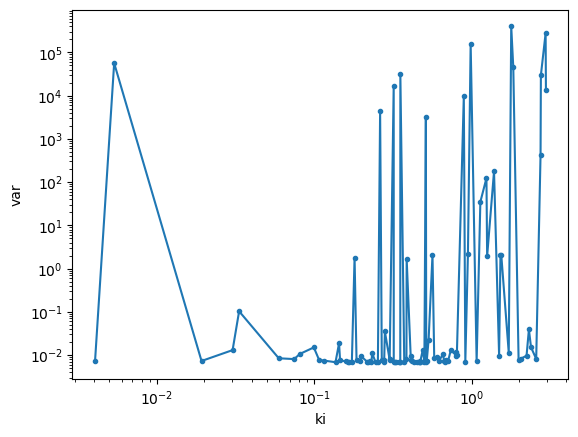

In [145]:
print(study.best_params,study.best_value)
study_df=study.trials_dataframe().sort_values(by='params_ki')
plt.loglog(study_df.params_ki[:100],study_df.value[:100],'.-')
plt.ylabel('var')
plt.xlabel('ki')
plt.show()

In [121]:
phase_out,data_dict=general_pi(phase_speed=phase_speed,time_exposure=100,
                        kp=0,ki=1e-7)
    #trial.set_user_attr("data", data_dict)
np.var(phase_out)

100%|██████████| 10000/10000 [00:00<00:00, 29585.88it/s]


15101.095478219095